#**Problem Statement**

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### importing the Necessary Libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [11]:
#importing dataset from google drive since the file is large in size
from google.colab import drive
drive.mount('/content/drive')

#changing the root location
root_path = '/content/drive/MyDrive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration'
os.chdir(root_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [12]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Train")
data_dir_test = pathlib.Path('Test')

In [13]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Define the dataset

Define some parameters for the loader:

In [14]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [16]:
#Train Set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),validation_split=0.2,seed=123,subset="training")

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [17]:
#Validation Set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),validation_split=0.2,seed=123,subset="validation")

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [18]:
# List out all the classes of skin cancer and store them in a list. 

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### One instance of all the nine classes present in the dataset

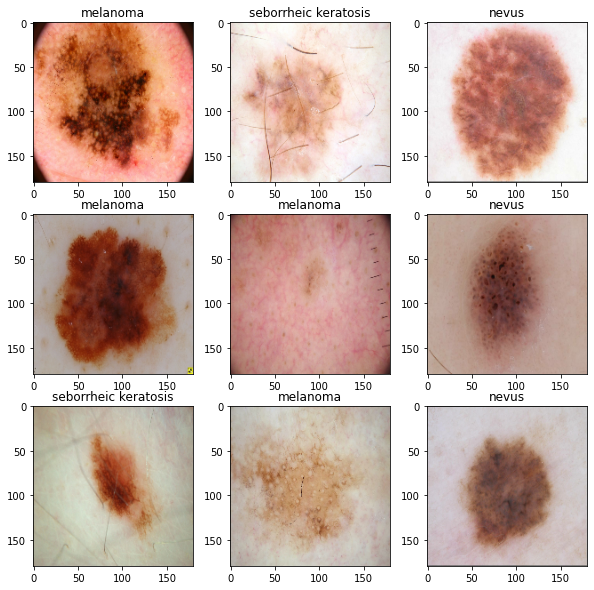

In [30]:
#Visualizing the classes

plt.figure(figsize=(10,10))

for images,labels in train_ds.take(1):
  for i in range (9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [31]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [51]:
#create the model

num_classes=9   #Output Neurons

model=Sequential([
                  layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height,img_width,3)),
                  layers.Conv2D(16,3,padding='same',activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(32,3,padding='same',activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(64,3,padding='same',activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Flatten(),
                  layers.Dense(128,activation=  'relu'),
                  layers.Dense(num_classes)

])

#### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [52]:
#choosing optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

#### Train the model

In [54]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 25ms/step - loss: 2.1110 - accuracy: 0.2282 - val_loss: 1.8549 - val_accuracy: 0.2975
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.6958 - accuracy: 0.3940 - val_loss: 1.6215 - val_accuracy: 0.4452
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4282 - accuracy: 0.5056 - val_loss: 1.4345 - val_accuracy: 0.5324
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3633 - accuracy: 0.5391 - val_loss: 1.5271 - val_accuracy: 0.4922
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2977 - accuracy: 0.5474 - val_loss: 1.3142 - val_accuracy: 0.5459
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2072 - accuracy: 0.5770 - val_loss: 1.4321 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.1281 - accuracy: 0.5971 - val_loss: 1.3190 - val_accuracy: 0.5615
Epoch 8/20
56

#### Visualizing training results

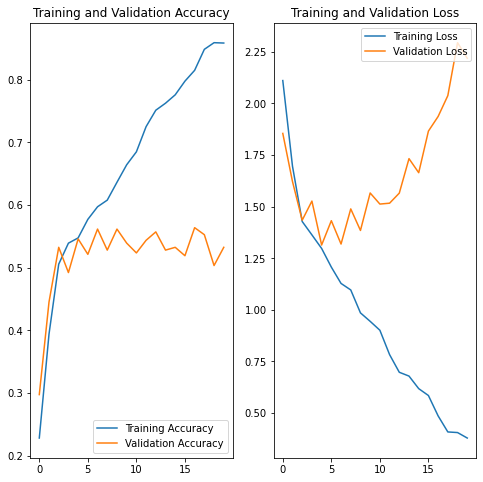

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####**Inference from Mode1 1:**

The training acccuracy keeps increasing but the training accuracy stalls at 55% which shows signs of overfitting.

As we can see from the plots that there is a huge margin between the training and test accuracy.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

###**Data Augmentation**

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using experimental Keras Preprocessing Layers

In [56]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

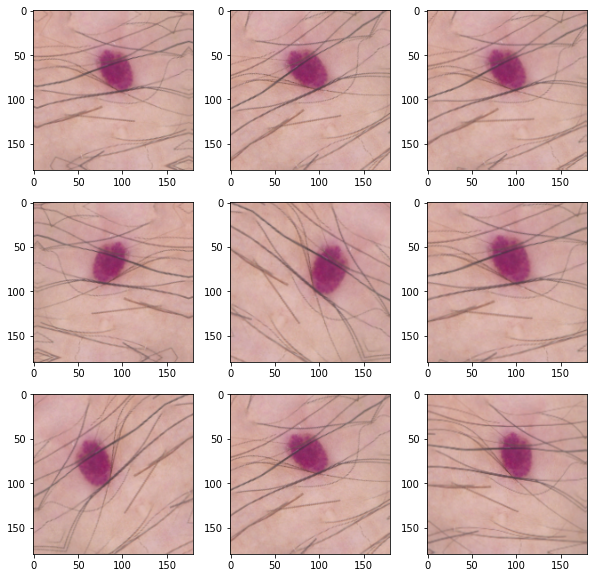

In [57]:
# Visualizing the augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))

### Create the model, compile and train the model


In [63]:
#Creating the new CNN with a dropout strategy
model=Sequential([
                  data_augmentation,
                  layers.experimental.preprocessing.Rescaling(scale=1./255),
                  layers.Conv2D(16,3,padding='same',activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(32,3,padding='same',activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(64,3,padding='same',activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Dropout(0.2),
                  layers.Flatten(),
                  layers.Dense(128,activation=  'relu'),
                  layers.Dense(num_classes)

])

#### Compiling the model

In [64]:
#choosing optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [65]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

#### Training the model

In [66]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 27ms/step - loss: 1.8786 - accuracy: 0.2952 - val_loss: 1.6648 - val_accuracy: 0.3602
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6228 - accuracy: 0.4118 - val_loss: 1.4790 - val_accuracy: 0.4877
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4924 - accuracy: 0.4771 - val_loss: 1.4675 - val_accuracy: 0.5101
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4293 - accuracy: 0.5084 - val_loss: 1.4520 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3821 - accuracy: 0.5089 - val_loss: 1.3928 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3660 - accuracy: 0.5112 - val_loss: 1.4144 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3638 - accuracy: 0.5067 - val_loss: 1.4683 - val_accuracy: 0.4944
Epoch 8/20
56

#### Visualizing the results

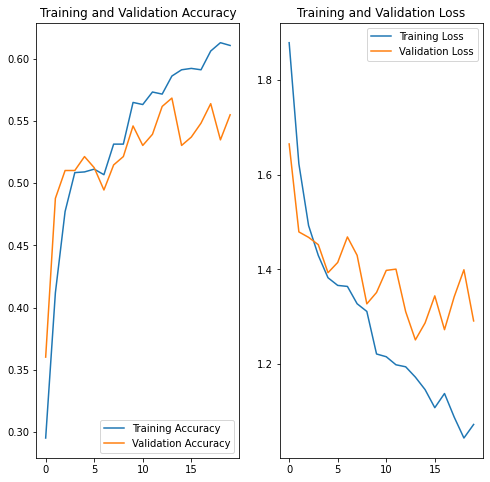

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####**Inference from Model 2:**
* After data augmentation and drop out layer addition, the results have improved significantly. The train and test accuracy are in range of 55-60% and are exhibiting a similar range of accuracy which means the model is not overfitting.
* The training and test losses graph also highlights a a trend of falling losses on both training and testing.

### **Finding the Distribution of the classes**


**Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.**

In [72]:
#function to check image distribution fo each class (image)
from pathlib import Path

def dist(class_name):
  data_dir_train = pathlib.Path("Train/"+class_name)
  paths1 = Path(data_dir_train).glob('**/*.jpg')
  cnt=len(list(paths1))
  print("{0} - {1}".format(data_dir_train,cnt))

In [73]:
#print the distribution
for i in class_names:
  dist(i)

Train/actinic keratosis - 114
Train/basal cell carcinoma - 376
Train/dermatofibroma - 95
Train/melanoma - 438
Train/nevus - 357
Train/pigmented benign keratosis - 462
Train/seborrheic keratosis - 77
Train/squamous cell carcinoma - 181
Train/vascular lesion - 139


####**Inference:**

From the above distribution we can infer:
* The "seborrheic keratosis" class has least samples
* The "pigmented benign keratosis" class has the most dominant samples

Which means we need to eliminate the class imbalance

###**Augmentation**

In [75]:
#Import the necessary library
!pip install Augmentor
import Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [76]:
#Setting path for Augmentation
path_to_training_dataset=os.getcwd()
path_to_training_dataset = path_to_training_dataset + "/Train"
print(path_to_training_dataset)

/content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train


In [78]:
#augmenting samples to test set
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F528FABDD50>: 100%|██████████| 500/500 [00:18<00:00, 27.39 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F528F7E8150>: 100%|██████████| 500/500 [00:18<00:00, 27.55 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F528F79F250>: 100%|██████████| 500/500 [00:18<00:00, 27.18 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5310043610>: 100%|██████████| 500/500 [01:25<00:00,  5.83 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F528E4224D0>: 100%|██████████| 500/500 [01:24<00:00,  5.94 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F52A6337E50>: 100%|██████████| 500/500 [00:18<00:00, 27.13 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F528F74FD90>: 100%|██████████| 500/500 [00:43<00:00, 11.60 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F528F368AD0>: 100%|██████████| 500/500 [00:18<00:00, 27.25 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/CNN/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F528FABD790>: 100%|██████████| 500/500 [00:19<00:00, 26.04 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [79]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [80]:
#check the new distribution
for i in class_names:
  dist(i)

Train/actinic keratosis - 614
Train/basal cell carcinoma - 876
Train/dermatofibroma - 595
Train/melanoma - 938
Train/nevus - 857
Train/pigmented benign keratosis - 962
Train/seborrheic keratosis - 577
Train/squamous cell carcinoma - 681
Train/vascular lesion - 639


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

###**Train the model on the data created using Augmentor**

In [81]:
batch_size = 32
img_height = 180
img_width = 180

####**Create a training dataset**

In [89]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory( data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),seed=123,validation_split = 0.2,subset ="training")

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####**Create a validation dataset**

In [90]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),seed=123,validation_split = 0.2,subset ="validation")

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create the model

In [97]:
#Creating the new CNN with a dropout strategy
model=Sequential([
                  layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)),
                  layers.Conv2D(16,3,padding='same',activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(32,3,padding='same',activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(64,3,padding='same',activation='relu'),
                  layers.MaxPooling2D(),
                  #layers.Dropout(0.2),
                  layers.Flatten(),
                  layers.Dense(128,activation=  'relu'),
                  layers.Dense(num_classes)

])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [98]:
#choosing optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [99]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 45, 45, 64)       

#### **Todo:**  Train your model

In [100]:
##use 50 epochs.
epochs = 30
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/30
169/169 [==============================] - 30s 171ms/step - loss: 1.6542 - accuracy: 0.3702 - val_loss: 1.5631 - val_accuracy: 0.4291
Epoch 2/30
169/169 [==============================] - 29s 168ms/step - loss: 1.2985 - accuracy: 0.5106 - val_loss: 1.2519 - val_accuracy: 0.5345
Epoch 3/30
169/169 [==============================] - 30s 170ms/step - loss: 1.0715 - accuracy: 0.5925 - val_loss: 1.0582 - val_accuracy: 0.6102
Epoch 4/30
169/169 [==============================] - 29s 169ms/step - loss: 0.8264 - accuracy: 0.7018 - val_loss: 0.9142 - val_accuracy: 0.6867
Epoch 5/30
169/169 [==============================] - 30s 170ms/step - loss: 0.6600 - accuracy: 0.7613 - val_loss: 0.8249 - val_accuracy: 0.7327
Epoch 6/30
169/169 [==============================] - 29s 168ms/step - loss: 0.5030 - accuracy: 0.8184 - val_loss: 0.7770 - val_accuracy: 0.7528
Epoch 7/30
169/169 [==============================] - 29s 169ms/step - loss: 0.3906 - accuracy: 0.8624 - val_loss: 0.8852 - val_ac

####**Visualize the model results**

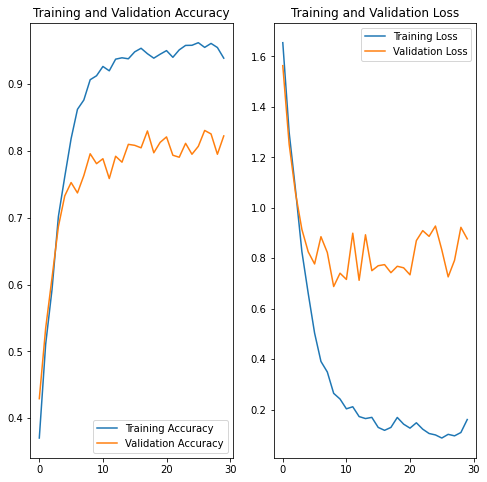

In [101]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Conclusion:**
We can see here that the training as well as the validation accuracy has increased in a good amount keeping the gap more or less the same as the previous model.The validation accuracy has gone up and looks better after treatment of class imbalance. Hence lesser chance of overfitting. This model is good to go now. If more than 30 epochs are used, the model will yield better results

